##### Spark setup and importing necessary dependecies

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, concat

spark = SparkSession.builder. \
config("spark.driver.memory", "4g"). \
config("spark.executor.memory", "4g").getOrCreate() 

In [3]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, TimestampType

##### CSV dataset loading - books_data

In [5]:
# Define your schema with suitable data types
schema = StructType([
    StructField("Title", StringType(), True),
    StructField("description", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("image", StringType(), True),
    StructField("previewLink", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("publishedDate", DateType(), True),
    StructField("infoLink", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("ratingsCount", DoubleType(), True)
])

In [6]:
# Read CSV file with specified schema and custom delimiter
book_data_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("delimiter", ",") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .schema(schema) \
    .load("books_data.csv")

In [7]:
display(book_data_df)

DataFrame[Title: string, description: string, authors: string, image: string, previewLink: string, publisher: string, publishedDate: date, infoLink: string, categories: string, ratingsCount: double]

In [8]:
book_data_df.show(truncate=10)

+----------+-----------+----------+----------+-----------+----------+-------------+----------+----------+------------+
|     Title|description|   authors|     image|previewLink| publisher|publishedDate|  infoLink|categories|ratingsCount|
+----------+-----------+----------+----------+-----------+----------+-------------+----------+----------+------------+
|Its Onl...|       NULL|['Julie...|http://...| http://...|      NULL|   1996-01-01|http://...|['Comic...|        NULL|
|Dr. Seu...| Philip ...|['Phili...|http://...| http://...| A&C Black|   2005-01-01|http://...|['Biogr...|        NULL|
|Wonderf...| This re...|['David...|http://...| http://...|      NULL|   2000-01-01|http://...|['Relig...|        NULL|
|Whisper...| Julia T...|['Veron...|http://...| http://...| iUniverse|   2005-02-01|http://...|['Ficti...|        NULL|
|Nation ...|       NULL|['Edwar...|      NULL| http://...|      NULL|   2003-03-01|http://...|      NULL|        NULL|
|The Chu...| In The ...|['Evere...|http://...| h

##### Data Preprocessing - books_data

In [9]:
# Count the total number of rows in the DataFrame
total_rows = book_data_df.count()

# Print the total number of rows
print("Total number of rows in the Book Data DataFrame:", total_rows)

Total number of rows in the Book Data DataFrame: 212404


In [10]:
# Count missing values in each column
missing_values = book_data_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in book_data_df.columns))

# Display the missing values count for each column
missing_values.show()

+-----+-----------+-------+-----+-----------+---------+-------------+--------+----------+------------+
|Title|description|authors|image|previewLink|publisher|publishedDate|infoLink|categories|ratingsCount|
+-----+-----------+-------+-----+-----------+---------+-------------+--------+----------+------------+
|    1|      68442|  31413|52075|      23836|    75886|        25576|   23836|     41199|      162652|
+-----+-----------+-------+-----+-----------+---------+-------------+--------+----------+------------+



In [11]:
# Drop rows with missing values in the 'Title' column
book_data_df = book_data_df.na.drop(subset=['Title'])

In [12]:
# Columns to drop
columns_to_drop = ['image', 'previewLink', 'infoLink','ratingsCount'] #ratingsCount column is dropped, since it has huge missing values

# Drop the specified columns
book_data_df = book_data_df.drop(*columns_to_drop)

In [13]:
textual_columns = ['description', 'publisher']

# Fill missing values with empty strings in textual columns
book_data_df = book_data_df.na.fill('', subset=textual_columns)

In [14]:
# Define the column to fill missing values for
categorical_column = ['categories']

# Fill missing values with 'Other' in the categories column
book_data_df = book_data_df.na.fill('Other', subset=categorical_column)

In [15]:
# Define the column to fill missing values for
author = ['authors']

# Fill missing values with 'Other' in the categories column
book_data_df = book_data_df.na.fill('unknown', subset=author)

In [16]:
# Count missing values in each column
missing_values = book_data_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in book_data_df.columns))

# Display the missing values count for each column
missing_values.show()

+-----+-----------+-------+---------+-------------+----------+
|Title|description|authors|publisher|publishedDate|categories|
+-----+-----------+-------+---------+-------------+----------+
|    0|          0|      0|        0|        25576|         0|
+-----+-----------+-------+---------+-------------+----------+



In [17]:
book_data_df.show(truncate=20)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+
|               Title|         description|             authors|           publisher|publishedDate|          categories|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+
|Its Only Art If I...|                    |    ['Julie Strain']|                    |   1996-01-01|['Comics & Graphi...|
|Dr. Seuss: Americ...|Philip Nel takes ...|      ['Philip Nel']|           A&C Black|   2005-01-01|['Biography & Aut...|
|Wonderful Worship...|This resource inc...|    ['David R. Ray']|                    |   2000-01-01|        ['Religion']|
|Whispers of the W...|Julia Thomas find...| ['Veronica Haddon']|           iUniverse|   2005-02-01|         ['Fiction']|
|Nation Dance: Rel...|                    |     ['Edward Long']|                    |   2003-03-01|               Other|
|The Church of Chr...|In The Chu

##### CSV dataset loading - books_rating

In [18]:
schema = StructType([
    StructField("Id", StringType(), True),
    StructField("Title", StringType(), True),
    StructField("Price", DoubleType(), True),
    StructField("User_id", StringType(), True),
    StructField("profileName", StringType(), True),
    StructField("review/helpfulness", StringType(), True),
    StructField("review/score", DoubleType(), True),
    StructField("review/time", StringType(), True),
    StructField("review/summary", StringType(), True),
    StructField("review/text", StringType(), True)
])

In [19]:
# Load the CSV file with the specified schema
book_rating_df = spark.read.format("csv") \
    .option("header", "true") \
    .schema(schema) \
    .load("Books_rating.csv")

In [20]:
book_rating_df.show(truncate=10)

+----------+----------+-----+----------+-----------+------------------+------------+-----------+--------------+-----------+
|        Id|     Title|Price|   User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+----------+----------+-----+----------+-----------+------------------+------------+-----------+--------------+-----------+
|1882931173|Its Onl...| NULL|AVCGYZL...| "Jim of...|               7/7|         4.0|  940636800|    Nice co...| This is...|
|0826414346|Dr. Seu...| NULL|A30TK6U...| Kevin K...|             10/10|         5.0| 1095724800|    Really ...| I don't...|
|0826414346|Dr. Seu...| NULL|A3UH4UZ...| John Gr...|             10/11|         5.0| 1078790400|    Essenti...| "If peo...|
|0826414346|Dr. Seu...| NULL|A2MVUWT...| "Roy E....|               7/7|         4.0| 1090713600|    Phlip N...| Theodor...|
|0826414346|Dr. Seu...| NULL|A22X4XU...| "D. H. ...|               3/3|         4.0| 1107993600|    Good ac...| "Philip...|
|0826414

##### Data Preprocessing - books_rating

In [21]:
# Count the total number of rows in the DataFrame
total_rows = book_rating_df.count()

# Print the total number of rows
print("Total number of rows in the Books Review DataFrame:", total_rows)

Total number of rows in the Books Review DataFrame: 3000000


In [22]:
# Count missing values in each column
missing_values = book_rating_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in book_rating_df.columns))

# Display the missing values count for each column
missing_values.show()

+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|  Price|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|  208|2519269| 562250|     562200|               367|       18064|         27|            65|         43|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [23]:
# Drop rows with missing values in 'Title' and 'User_id' columns
book_rating_df = book_rating_df.na.drop(subset=['Title', 'User_id','review/score'])

In [24]:
# Count the total number of rows in the DataFrame
total_rows = book_rating_df.count()

# Print the total number of rows
print("Total number of rows in the Books Review DataFrame:", total_rows)

Total number of rows in the Books Review DataFrame: 2420261


In [25]:
# Count missing values in each column
missing_values = book_rating_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in book_rating_df.columns))

# Display the missing values count for each column
missing_values.show()

+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|  Price|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|    0|2009203|      0|         99|                 0|           0|          0|            29|          5|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [26]:
# Drop the 'Price' column
book_rating_df = book_rating_df.drop('Price')

In [27]:
textual_columns = ['profileName','review/summary', 'review/text']

# Fill missing values with empty strings in textual columns
book_rating_df = book_rating_df.na.fill('', subset=textual_columns)

In [28]:
# Count missing values in each column
missing_values = book_rating_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in book_rating_df.columns))

# Display the missing values count for each column
missing_values.show()

+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|    0|      0|          0|                 0|           0|          0|             0|          0|
+---+-----+-------+-----------+------------------+------------+-----------+--------------+-----------+



In [29]:
book_rating_df.show(truncate=12)

+----------+------------+------------+------------+------------------+------------+-----------+--------------+------------+
|        Id|       Title|     User_id| profileName|review/helpfulness|review/score|review/time|review/summary| review/text|
+----------+------------+------------+------------+------------------+------------+-----------+--------------+------------+
|1882931173|Its Only ...|AVCGYZL8F...|"Jim of O...|               7/7|         4.0|  940636800|  Nice coll...|This is o...|
|0826414346|Dr. Seuss...|A30TK6U7D...|Kevin Kil...|             10/10|         5.0| 1095724800|  Really En...|I don't c...|
|0826414346|Dr. Seuss...|A3UH4UZ4R...|John Granger|             10/11|         5.0| 1078790400|  Essential...|"If peopl...|
|0826414346|Dr. Seuss...|A2MVUWT45...|"Roy E. P...|               7/7|         4.0| 1090713600|  Phlip Nel...|Theodore ...|
|0826414346|Dr. Seuss...|A22X4XUPK...|"D. H. Ri...|               3/3|         4.0| 1107993600|  Good acad...|"Philip N...|
|0826414

In [30]:
from pyspark.sql.functions import col, from_unixtime

# Assuming 'review/time' is the column containing Unix timestamps in string format
# Convert the string column to a numeric data type (LongType)
book_rating_df = book_rating_df.withColumn('review_time_unix', col('review/time').cast('long'))

# Convert the Unix timestamps to a human-readable date format
book_rating_df = book_rating_df.withColumn('review_time_formatted', from_unixtime('review_time_unix'))

# Drop the intermediate 'review_time_unix' column if needed
book_rating_df = book_rating_df.drop('review_time_unix')

book_rating_df = book_rating_df.drop('review/time')

In [31]:
book_rating_df.show(truncate=10)

+----------+----------+----------+-----------+------------------+------------+--------------+-----------+---------------------+
|        Id|     Title|   User_id|profileName|review/helpfulness|review/score|review/summary|review/text|review_time_formatted|
+----------+----------+----------+-----------+------------------+------------+--------------+-----------+---------------------+
|1882931173|Its Onl...|AVCGYZL...| "Jim of...|               7/7|         4.0|    Nice co...| This is...|           1999-10...|
|0826414346|Dr. Seu...|A30TK6U...| Kevin K...|             10/10|         5.0|    Really ...| I don't...|           2004-09...|
|0826414346|Dr. Seu...|A3UH4UZ...| John Gr...|             10/11|         5.0|    Essenti...| "If peo...|           2004-03...|
|0826414346|Dr. Seu...|A2MVUWT...| "Roy E....|               7/7|         4.0|    Phlip N...| Theodor...|           2004-07...|
|0826414346|Dr. Seu...|A22X4XU...| "D. H. ...|               3/3|         4.0|    Good ac...| "Philip...

#### Basic Exploratory Data Analysis (EDA) - books_data

In [32]:
book_data_df.show(truncate=20)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+
|               Title|         description|             authors|           publisher|publishedDate|          categories|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+
|Its Only Art If I...|                    |    ['Julie Strain']|                    |   1996-01-01|['Comics & Graphi...|
|Dr. Seuss: Americ...|Philip Nel takes ...|      ['Philip Nel']|           A&C Black|   2005-01-01|['Biography & Aut...|
|Wonderful Worship...|This resource inc...|    ['David R. Ray']|                    |   2000-01-01|        ['Religion']|
|Whispers of the W...|Julia Thomas find...| ['Veronica Haddon']|           iUniverse|   2005-02-01|         ['Fiction']|
|Nation Dance: Rel...|                    |     ['Edward Long']|                    |   2003-03-01|               Other|
|The Church of Chr...|In The Chu

In [33]:
from pyspark.sql import functions as F

In [34]:
# Check for duplicate values in the "Title" column
duplicate_titles = book_data_df.groupBy("Title").count().filter(col("count") > 1)

# Show the duplicate titles, if any
duplicate_titles.show()

+-----+-----+
|Title|count|
+-----+-----+
+-----+-----+



In [35]:
# Concatenate the values of Title, Author, and PublishedDate columns into a single column
concatenated_column = concat(col("Title"), col("authors"))

# Check for duplicate values in the concatenated column
duplicate_rows = book_data_df.groupBy(concatenated_column).count().filter(col("count") > 1)

# Show the duplicate rows, if any
duplicate_rows.show(truncate=False)

+----------------------+-----+
|concat(Title, authors)|count|
+----------------------+-----+
+----------------------+-----+



In [36]:
# Find the number of unique categories
unique_categories_count = book_data_df.select("categories").distinct().count()

# Print the number of unique categories
print("Number of unique categories:", unique_categories_count)

Number of unique categories: 10884


#### Basic Exploratory Data Analysis (EDA) - books_data

In [37]:
# Group by categories and count the number of books
books_per_category = book_data_df.groupBy("categories").agg(F.count("Title").alias("num_books"))

# Sort the DataFrame by the number of books in descending order
books_per_category_sorted = books_per_category.orderBy(F.desc("num_books"))

# Show the sorted DataFrame
books_per_category_sorted.show()

+--------------------+---------+
|          categories|num_books|
+--------------------+---------+
|               Other|    41198|
|         ['Fiction']|    23419|
|        ['Religion']|     9459|
|         ['History']|     9330|
|['Juvenile Fiction']|     6643|
|['Biography & Aut...|     6324|
|['Business & Econ...|     5625|
|       ['Computers']|     4312|
|  ['Social Science']|     3834|
|['Juvenile Nonfic...|     3446|
|         ['Science']|     2623|
|       ['Education']|     2611|
|         ['Cooking']|     2445|
|['Sports & Recrea...|     2267|
|['Family & Relati...|     2178|
|['Literary Critic...|     2147|
|           ['Music']|     2106|
|         ['Medical']|     2079|
|             ['Art']|     2054|
|['Body, Mind & Sp...|     2049|
+--------------------+---------+
only showing top 20 rows



In [38]:
# Filter the categories with less than 5 books
categories_less_than_3_books = books_per_category.filter("num_books < 3")

# Count the number of categories with less than 5 books
num_categories_less_than_3_books = categories_less_than_3_books.count()

# Show the number of categories with less than 5 books
print("Number of categories with less than 3 books:", num_categories_less_than_3_books)

Number of categories with less than 3 books: 8148


In [39]:
# Find the number of unique authors
unique_authors_count = book_data_df.select("authors").distinct().count()

# Print the number of unique authors
print("Number of unique authors:", unique_authors_count)

Number of unique authors: 127278


In [40]:
# Group by categories and count the number of books
books_per_author = book_data_df.groupBy("authors").agg(F.count("Title").alias("num_books"))

# Sort the DataFrame by the number of books in descending order
books_per_author_sorted = books_per_author.orderBy(F.desc("num_books"))

# Show the sorted DataFrame
books_per_author_sorted.show()

+--------------------+---------+
|             authors|num_books|
+--------------------+---------+
|             unknown|    31413|
|       ['Rose Arny']|      236|
|['William Shakesp...|      191|
|['Library of Cong...|      178|
| ['Agatha Christie']|      142|
|['Erle Stanley Ga...|      124|
|   ["Louis L'Amour"]|      123|
| ['Charles Dickens']|       89|
|['Edgar Rice Burr...|       85|
|       ['Zane Grey']|       75|
| ['Rudyard Kipling']|       75|
|   ['Ann M. Martin']|       71|
|   ['Carolyn Keene']|       71|
|      ['Mark Twain']|       70|
|    ['Isaac Asimov']|       70|
|     ['Henry James']|       63|
|   ['Joseph Conrad']|       62|
|    ['Nora Roberts']|       62|
|['Robert Louis St...|       62|
|         ['Various']|       60|
+--------------------+---------+
only showing top 20 rows



#### Basic Exploratory Data Analysis (EDA) - books_rating

In [41]:
book_rating_df.show(truncate=10)

+----------+----------+----------+-----------+------------------+------------+--------------+-----------+---------------------+
|        Id|     Title|   User_id|profileName|review/helpfulness|review/score|review/summary|review/text|review_time_formatted|
+----------+----------+----------+-----------+------------------+------------+--------------+-----------+---------------------+
|1882931173|Its Onl...|AVCGYZL...| "Jim of...|               7/7|         4.0|    Nice co...| This is...|           1999-10...|
|0826414346|Dr. Seu...|A30TK6U...| Kevin K...|             10/10|         5.0|    Really ...| I don't...|           2004-09...|
|0826414346|Dr. Seu...|A3UH4UZ...| John Gr...|             10/11|         5.0|    Essenti...| "If peo...|           2004-03...|
|0826414346|Dr. Seu...|A2MVUWT...| "Roy E....|               7/7|         4.0|    Phlip N...| Theodor...|           2004-07...|
|0826414346|Dr. Seu...|A22X4XU...| "D. H. ...|               3/3|         4.0|    Good ac...| "Philip...

In [42]:
# Concatenate the values of Title, Author, and PublishedDate columns into a single column
concatenated_column = concat(col("Title"), col("User_id"))

# Check for duplicate values in the concatenated column
duplicate_rows = book_rating_df.groupBy(concatenated_column).count().filter(col("count") > 1)

# Show the duplicate rows, if any
duplicate_rows.show(truncate=False)

+-------------------------------------------------------------------------------+-----+
|concat(Title, User_id)                                                         |count|
+-------------------------------------------------------------------------------+-----+
|The Scarlet Letter A RomanceA1ABDWJU9RTUWU                                     |6    |
|The Scarlet Letter A RomanceA4LD04RELGYW8                                      |6    |
|The Scarlet Letter A RomanceA6TPHIXWU4Y7K                                      |5    |
|FoundationA1LVZOK9F7K4CN                                                       |3    |
|FoundationA2NTPZZ5FS19Q                                                        |3    |
|FoundationA1C58YXM2A30CY                                                       |3    |
|FoundationA3BNPGALC1HI4X                                                       |3    |
|FoundationA2924CRHEV9B3                                                        |3    |
|FoundationA1N5JCYDWCOMTB       

In [43]:
# Count the total number of duplicate rows
total_duplicates = duplicate_rows.count()
print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 182481


In [44]:
# Group by Title and count distinct User_id entries, then sort in descending order
title_user_count = book_rating_df.groupBy("Title").agg(F.countDistinct("User_id").alias("user_count")) \
                                  .orderBy(F.desc("user_count"))

# Show the results
title_user_count.show()

+--------------------+----------+
|               Title|user_count|
+--------------------+----------+
|Harry Potter and ...|      3646|
|          The Hobbit|      3567|
|The Hobbit There ...|      3566|
|The Hobbitt, or t...|      3551|
|The Hobbit or The...|      3500|
|The Hobbit; Or, T...|      3398|
|Unfit for Command...|      2933|
|      Atlas Shrugged|      2628|
|  Rich Dad, Poor Dad|      2231|
|The Catcher in th...|      2125|
|The Catcher in th...|      2116|
|ERAGON: INHERITAN...|      2116|
|THE CATCHER IN TH...|      2106|
|The Alchemist: A ...|      1911|
|           The Giver|      1868|
|The Lord Of The R...|      1849|
|The Lord of the R...|      1848|
|The Lord of the R...|      1847|
|The Lord of the R...|      1842|
|The Lord of the R...|      1840|
+--------------------+----------+
only showing top 20 rows



In [45]:
title_user_count.show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------+
|                                                                                               Title|user_count|
+----------------------------------------------------------------------------------------------------+----------+
|                                                               Harry Potter and The Sorcerer's Stone|      3646|
|                                                                                          The Hobbit|      3567|
|                                                                     The Hobbit There and Back Again|      3566|
|                                    The Hobbitt, or there and back again; illustrated by the author.|      3551|
|                                                                  The Hobbit or There and Back Again|      3500|
|                                                                The Hobbit; Or, There a

In [46]:
# Filter rows where the book title is equal to specific_value
filtered_df = book_data_df.filter(book_data_df["Title"] == "The Hobbit There and Back Again")

# Show the filtered DataFrame
filtered_df.show()

+--------------------+--------------------+--------------------+---------+-------------+--------------------+
|               Title|         description|             authors|publisher|publishedDate|          categories|
+--------------------+--------------------+--------------------+---------+-------------+--------------------+
|The Hobbit There ...|The adventures of...|['John Ronald Reu...|         |   1966-01-01|['Adventure stori...|
+--------------------+--------------------+--------------------+---------+-------------+--------------------+



#### Merge the dataframes

In [47]:
# Join the DataFrames based on the "Title" column
merged_df = book_data_df.join(book_rating_df, on="Title")

# Drop one of the "Title" columns (assuming it's from book_rating_df)
merged_df = merged_df.drop(book_rating_df["Title"])

# Show the resulting DataFrame
merged_df.show(truncate=5)

+-----+-----------+-------+---------+-------------+----------+-----+-------+-----------+------------------+------------+--------------+-----------+---------------------+
|Title|description|authors|publisher|publishedDate|categories|   Id|User_id|profileName|review/helpfulness|review/score|review/summary|review/text|review_time_formatted|
+-----+-----------+-------+---------+-------------+----------+-----+-------+-----------+------------------+------------+--------------+-----------+---------------------+
|$5...|           |  un...|         |         NULL|     Other|09...|  AO...|      "C...|             20/20|         3.0|         Go...|      It...|                20...|
|'H...|           |  un...|         |         NULL|     Other|B0...|  A1...|      "J...|               1/1|         5.0|         Sl...|      I ...|                20...|
|'H...|           |  un...|         |         NULL|     Other|B0...|  AG...|      "C...|               1/1|         4.0|         Wh...|      I'...|   

In [48]:
merged_df.columns

['Title',
 'description',
 'authors',
 'publisher',
 'publishedDate',
 'categories',
 'Id',
 'User_id',
 'profileName',
 'review/helpfulness',
 'review/score',
 'review/summary',
 'review/text',
 'review_time_formatted']

In [49]:
# Get the counts of rows in each DataFrame
book_rating_count = book_rating_df.count()
merged_count = merged_df.count()

# Compare the counts and print messages accordingly
if book_rating_count == merged_count:
    print("No reviews have been dropped.")
else:
    print("The number of dropped reviews are : ", book_rating_count-merged_count)

The number of dropped reviews are :  6208


#### Data preprocessing - Merged dataframe

In [50]:
# Count missing values in each column
merged_missing_values = merged_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in merged_df.columns))

# Display the missing values count for each column
merged_missing_values.show()

+-----+-----------+-------+---------+-------------+----------+---+-------+-----------+------------------+------------+--------------+-----------+---------------------+
|Title|description|authors|publisher|publishedDate|categories| Id|User_id|profileName|review/helpfulness|review/score|review/summary|review/text|review_time_formatted|
+-----+-----------+-------+---------+-------------+----------+---+-------+-----------+------------------+------------+--------------+-----------+---------------------+
|    0|          0|      0|        0|       287674|         0|  0|      0|          0|                 0|           0|             0|          0|                    5|
+-----+-----------+-------+---------+-------------+----------+---+-------+-----------+------------------+------------+--------------+-----------+---------------------+



In [51]:
from pyspark.ml.feature import StringIndexer

user_indexer = StringIndexer(inputCol="User_id", outputCol="user_index")
indexerModel = user_indexer.fit(merged_df)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(merged_df)
indexed_df.show(truncate=20)

+--------------------+-----------+-------+---------+-------------+----------+----------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+
|               Title|description|authors|publisher|publishedDate|categories|        Id|       User_id|         profileName|review/helpfulness|review/score|      review/summary|         review/text|review_time_formatted|user_index|
+--------------------+-----------+-------+---------+-------------+----------+----------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+
|$5 Dollar Menus f...|           |unknown|         |         NULL|     Other|0972432779| AOVKTRWGT79PA|"C. R Vachio ""Ch...|             20/20|         3.0|Good, but with pr...|It's a decent boo...|  2004-08-05 06:00:00|  945746.0|
|'HUMBLE PIE , MY ...|           |unknown|         |         NULL|     O

In [52]:
title_indexer = StringIndexer(inputCol="Title", outputCol="title_index")
indexerModel = title_indexer.fit(indexed_df)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(indexed_df)
indexed_df.show(truncate=20)

+--------------------+-----------+-------+---------+-------------+----------+----------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+-----------+
|               Title|description|authors|publisher|publishedDate|categories|        Id|       User_id|         profileName|review/helpfulness|review/score|      review/summary|         review/text|review_time_formatted|user_index|title_index|
+--------------------+-----------+-------+---------+-------------+----------+----------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+-----------+
|$5 Dollar Menus f...|           |unknown|         |         NULL|     Other|0972432779| AOVKTRWGT79PA|"C. R Vachio ""Ch...|             20/20|         3.0|Good, but with pr...|It's a decent boo...|  2004-08-05 06:00:00|  945746.0|   135917.0|
|'HUMBLE PIE , MY ...|  

In [82]:
from pyspark.sql.functions import when

merged_df = merged_df.withColumn("review/score", when(merged_df["review/score"] > 5, 0).otherwise(merged_df["review/score"]))

#### EDA on Merged Data

In [53]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [83]:
# Register the DataFrame as a temporary view
merged_df.createOrReplaceTempView("books")

In [84]:
# Authors by Number of Books

author_book_count = spark.sql("""
    SELECT authors, COUNT(*) AS book_count
    FROM books
    WHERE authors != 'unknown'
    GROUP BY authors
    ORDER BY book_count DESC
""")

author_book_count.show()

+--------------------+----------+
|             authors|book_count|
+--------------------+----------+
|     ['Jane Austen']|     32267|
|['J. R. R. Tolkien']|     30467|
| ['Charles Dickens']|     17763|
|  ['John Steinbeck']|     12730|
|     ['C. S. Lewis']|     10566|
|   ['Lewis Carroll']|     10099|
|['John Ronald Reu...|     10011|
|   ['Kurt Vonnegut']|      9899|
|    ['Emily Bronte']|      9397|
|['F. Scott Fitzge...|      8606|
|      ['Harper Lee']|      8302|
|['Charlotte Brontë']|      8112|
|   ['George Orwell']|      7937|
|   ['Aldous Huxley']|      7498|
|    ['Ray Bradbury']|      7429|
| ['Agatha Christie']|      7368|
|    ['Stephen King']|      7130|
|      ['Mark Twain']|      6800|
|    ['Rey Terciero']|      6489|
|['Louisa May Alco...|      6150|
+--------------------+----------+
only showing top 20 rows



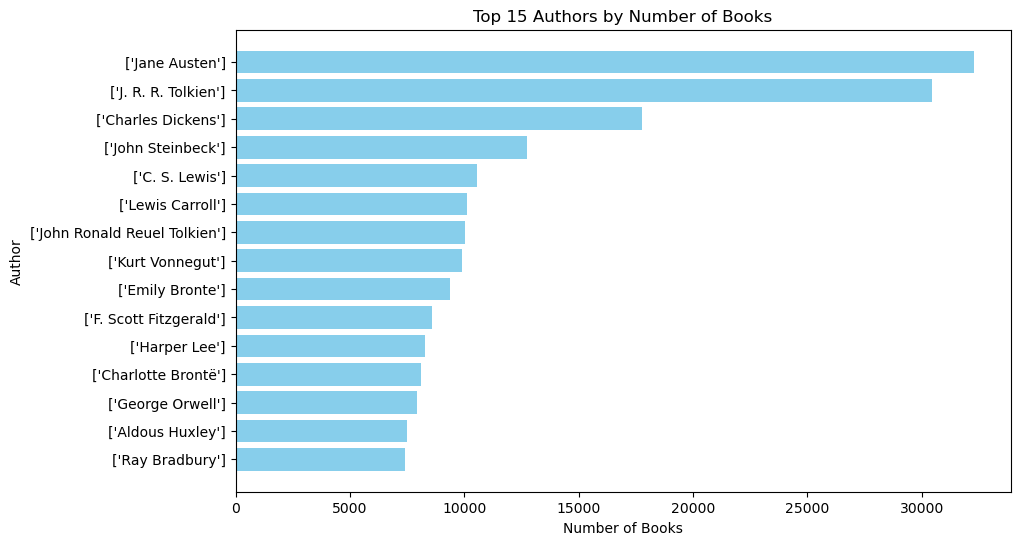

In [85]:
# Plot Top 15 Authors by Number of Books

author_book_count_df = author_book_count.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(author_book_count_df['authors'][:15], author_book_count_df['book_count'][:15], color='skyblue')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.title('Top 15 Authors by Number of Books')
plt.gca().invert_yaxis()
plt.show()

In [86]:
# Books by Average Review Score

book_avg_score = spark.sql("""
    SELECT LOWER(Title) AS book_title, AVG(`review/score`) AS avg_score
    FROM books
    GROUP BY book_title
    ORDER BY avg_score DESC
""")

book_avg_score.show()

+--------------------+---------+
|          book_title|avg_score|
+--------------------+---------+
|langer samstag: r...|      5.0|
|fundamental probl...|      5.0|
|hey, mister: afte...|      5.0|
|queen lucia: make...|      5.0|
|hide and shriek i...|      5.0|
|garlic and oil: p...|      5.0|
|pura vida!: gay a...|      5.0|
|an encyclopedia o...|      5.0|
|rudyard kipling's...|      5.0|
|grave review: a j...|      5.0|
|history of the is...|      5.0|
|             annuals|      5.0|
|seeds of grace: a...|      5.0|
|hartley field: poems|      5.0|
|a palestinian sta...|      5.0|
|bartleby of the m...|      5.0|
|ivor horton's beg...|      5.0|
|  fixed point theory|      5.0|
|american wildlife...|      5.0|
|lapd: patrol, swa...|      5.0|
+--------------------+---------+
only showing top 20 rows



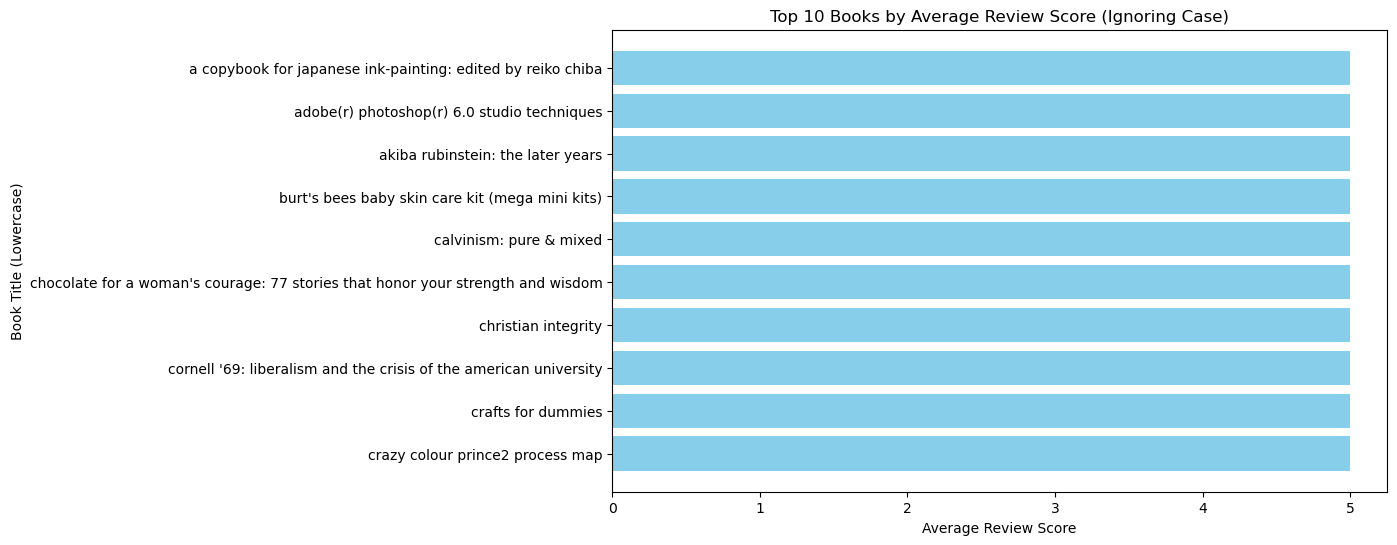

In [91]:
# Plot Top 15 Books by Average Review Score

book_avg_score_df = book_avg_score.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(book_avg_score_df['book_title'][:10], book_avg_score_df['avg_score'][:10], color='skyblue')
plt.xlabel('Average Review Score')
plt.ylabel('Book Title (Lowercase)')
plt.title('Top 10 Books by Average Review Score (Ignoring Case)')
plt.gca().invert_yaxis()
plt.show()

In [88]:
# Book count for each category

books_per_category = spark.sql("""
    SELECT categories, COUNT(*) AS book_count
    FROM books
    GROUP BY categories
    ORDER BY book_count DESC
""")

books_per_category.show()

+--------------------+----------+
|          categories|book_count|
+--------------------+----------+
|         ['Fiction']|    652908|
|               Other|    447230|
|['Juvenile Fiction']|    143113|
|['Biography & Aut...|     88923|
|        ['Religion']|     85878|
|         ['History']|     76250|
|['Business & Econ...|     55193|
|       ['Computers']|     32280|
|         ['Cooking']|     25846|
|  ['Social Science']|     25605|
|       ['Self-Help']|     24846|
|['Family & Relati...|     24204|
|['Juvenile Nonfic...|     23806|
|['Body, Mind & Sp...|     22992|
|['Young Adult Fic...|     21128|
|['Health & Fitness']|     20687|
|         ['Science']|     20135|
|['Political Scien...|     19523|
|['Sports & Recrea...|     18138|
|      ['Philosophy']|     17157|
+--------------------+----------+
only showing top 20 rows



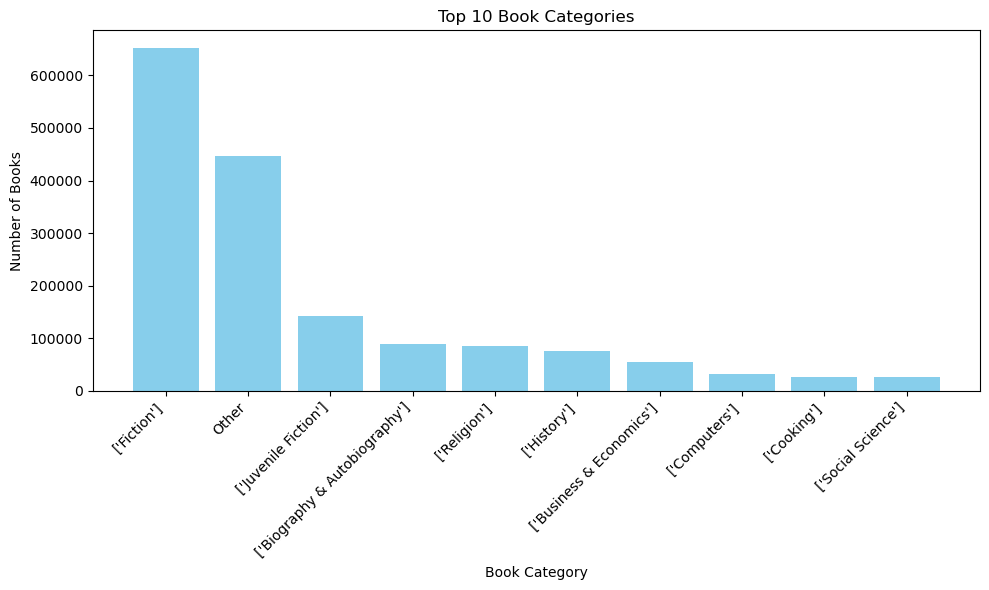

In [89]:
# Plot Top 10 Book Categories

top_categories = books_per_category.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_categories['categories'], top_categories['book_count'], color='skyblue')
plt.xlabel('Book Category')
plt.ylabel('Number of Books')
plt.title('Top 10 Book Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Data preparataion

In [62]:
from pyspark.ml.feature import StringIndexer

user_indexer = StringIndexer(inputCol="User_id", outputCol="user_index")
indexerModel = user_indexer.fit(book_rating_df)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(book_rating_df)
indexed_df.show(truncate=20)

+----------+--------------------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|      review/summary|         review/text|review_time_formatted|user_index|
+----------+--------------------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|Nice collection o...|This is only for ...|  1999-10-23 06:00:00|  167342.0|
|0826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0|   Really Enjoyed It|I don't care much...|  2004-09-21 06:00:00|      64.0|
|0826414346|Dr. Seuss: Americ...|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0|Essential for 

In [63]:
title_indexer = StringIndexer(inputCol="Title", outputCol="title_index")
indexerModel = title_indexer.fit(indexed_df)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(indexed_df)
indexed_df.show(truncate=20)

+----------+--------------------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+-----------+
|        Id|               Title|       User_id|         profileName|review/helpfulness|review/score|      review/summary|         review/text|review_time_formatted|user_index|title_index|
+----------+--------------------+--------------+--------------------+------------------+------------+--------------------+--------------------+---------------------+----------+-----------+
|1882931173|Its Only Art If I...| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|Nice collection o...|This is only for ...|  1999-10-23 06:00:00|  167342.0|   164573.0|
|0826414346|Dr. Seuss: Americ...|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0|   Really Enjoyed It|I don't care much...|  2004-09-21 06:00:00|      64.0|    37770.0|
|0826414346|Dr. Seuss: Americ...|A3UH4UZ4RSVO82|       

In [64]:
# Count the distinct user IDs
unique_user_ids = indexed_df.select('user_index').distinct().count()

# Print the count of unique user IDs
print("Number of unique user IDs:", unique_user_ids)

Number of unique user IDs: 1004218


In [65]:
# Selecting the required columns
new_df = indexed_df.select("user_index", "title_index", "review/score").limit(1000)

In [66]:
from pyspark.sql.functions import col

# List of columns to convert to integer
columns_to_convert = ['user_index', 'title_index', 'review/score']

# Iterate over each column and cast its data type to integer
for col_name in columns_to_convert:
    new_df = new_df.withColumn(col_name, col(col_name).cast("integer"))

In [67]:
# Count the distinct user IDs
unique_user_ids_count = new_df.select('user_index').distinct().count()

# Print the count of unique user IDs
print("Number of unique user IDs:", unique_user_ids_count)

Number of unique user IDs: 965


In [68]:
# Count the distinct user IDs
unique_user_idst = new_df.select('user_index').distinct().count()

# Print the count of unique user IDs
print("Number of unique user IDs:", unique_user_ids_count)

Number of unique user IDs: 965


In [69]:
new_df.show(10)

+----------+-----------+------------+
|user_index|title_index|review/score|
+----------+-----------+------------+
|    167342|     164573|           4|
|        64|      37770|           5|
|    105603|      37770|           5|
|      4472|      37770|           4|
|     31628|      37770|           4|
|      3581|      37770|           4|
|         0|      37770|           5|
|    637127|      37770|           5|
|    130564|      37770|           5|
|    837130|      37770|           4|
+----------+-----------+------------+
only showing top 10 rows



In [70]:
train_df, test_df = new_df.randomSplit([0.8, 0.2])

In [71]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

#### Hyperparameter Tuning

In [72]:
# Define arrays for hyperparameters
iterations_array = [5, 10, 20]
regularization_parameter = 0.1
rank = 2

# Initialize variables to store best parameters and corresponding RMSE
best_iteration = float("inf")
best_rmse = float("inf")
best_regularization_parameter= float("inf")
best_rank=float("inf")

# Loop through each combination of hyperparameters
for iterations in iterations_array:
            # Initialize ALS model with current hyperparameters
            als = ALS(maxIter=iterations, 
                      regParam=regularization_parameter,
                      rank=rank,
                      userCol="user_index", 
                      itemCol="title_index", 
                      ratingCol="review/score",
                      coldStartStrategy="drop")

            # Fit the model to the training data
            model = als.fit(train_df)

            # Make predictions on the test data
            predictions = model.transform(test_df)

            # Filter out null predictions
            new_predictions = predictions.filter(col('prediction').isNotNull())

            # Evaluate the model using RMSE
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="review/score", predictionCol="prediction")
            rmse = evaluator.evaluate(new_predictions)

            # Print RMSE for current combination of hyperparameters
            print("Parameters: Iterations={}, Regularization={}, Rank={}".format(iterations, regularization_parameter, rank))
            print("RMSE:", rmse)
            print("=" * 40)

            # Update best parameters if current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_iteration = iterations
                

print("Best Iteration Parameter:", best_iteration)
print("Best RMSE:", best_rmse)

Parameters: Iterations=5, Regularization=0.1, Rank=2
RMSE: 3.53437137679772
Parameters: Iterations=10, Regularization=0.1, Rank=2
RMSE: 3.2509155928880182
Parameters: Iterations=20, Regularization=0.1, Rank=2
RMSE: 3.0935479981043543
Best Iteration Parameter: 20
Best RMSE: 3.0935479981043543


In [73]:
# Define arrays for hyperparameters
regularization_array = [0.2, 0.3]
rank_array = [4, 6]

# Loop through each combination of hyperparameters
for regularization_parameter in regularization_array:
    for rank in rank_array:
            # Initialize ALS model with current hyperparameters
            als = ALS(maxIter=best_iteration, 
                      regParam=regularization_parameter,
                      rank=rank,
                      userCol="user_index", 
                      itemCol="title_index", 
                      ratingCol="review/score",
                      coldStartStrategy="drop")

            # Fit the model to the training data
            model = als.fit(train_df)

            # Make predictions on the test data
            predictions = model.transform(test_df)

            # Filter out null predictions
            new_predictions = predictions.filter(col('prediction').isNotNull())

            # Evaluate the model using RMSE
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="review/score", predictionCol="prediction")
            rmse = evaluator.evaluate(new_predictions)

            # Print RMSE for current combination of hyperparameters
            print("Parameters: Iterations={}, Regularization={}, Rank={}".format(iterations, regularization_parameter, rank))
            print("RMSE:", rmse)
            print("=" * 40)

            # Update best parameters if current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_rank = rank
                best_regularization_parameter = regularization_parameter

print("Best Regularization Parameter", best_regularization_parameter)
print("Best Rank:", best_rank)
print("Best Iteration:", best_iteration)
print("Best RMSE:", best_rmse)

Parameters: Iterations=20, Regularization=0.2, Rank=4
RMSE: 2.9136386699528094
Parameters: Iterations=20, Regularization=0.2, Rank=6
RMSE: 3.066840514449097
Parameters: Iterations=20, Regularization=0.3, Rank=4
RMSE: 2.9545715204818994
Parameters: Iterations=20, Regularization=0.3, Rank=6
RMSE: 3.0255949901313586
Best Regularization Parameter 0.2
Best Rank: 4
Best Iteration: 20
Best RMSE: 2.9136386699528094


In [74]:
# Initialize ALS model
als = ALS(maxIter=best_iteration, 
          regParam=best_regularization_parameter,
          rank=best_rank,
          userCol="user_index", 
          itemCol="title_index", 
          ratingCol="review/score",
          coldStartStrategy="drop")

# Fit the model to the training data
model = als.fit(train_df)

In [75]:
predictions = model.transform(test_df)
predictions.show(10)

+----------+-----------+------------+----------+
|user_index|title_index|review/score|prediction|
+----------+-----------+------------+----------+
|    196241|       3686|           4|  3.812551|
|     17466|       3461|           4|  3.494738|
|    311528|       3461|           5|  3.494738|
|         1|       3686|           5|-0.6416191|
|     20256|       3461|           5|  3.494738|
|      1330|       3461|           4| 2.7957904|
|      5183|       3423|           3|  2.086195|
|         8|       3461|           4|  3.494738|
|         7|      70821|           5| -2.509263|
|    224395|       3461|           5|  3.494738|
+----------+-----------+------------+----------+
only showing top 10 rows



In [76]:
new_predictions = predictions.filter(col('prediction').isNotNull())

evaluator = RegressionEvaluator(metricName="rmse", labelCol="review/score", predictionCol="prediction")
rmse = evaluator.evaluate(new_predictions)
print("RMSE:", rmse)

RMSE: 2.9136386699528094


#### Recommendation Representation

In [77]:
predictions.join(indexed_df, "user_index").select("user_index", "Title", "prediction").show(5)

+----------+--------------------+----------+
|user_index|               Title|prediction|
+----------+--------------------+----------+
|         0|Dr. Seuss: Americ...| 1.4791586|
|         0|Dealing With Disa...| 1.4791586|
|         0|Communicating wit...| 1.4791586|
|         0|Alternative Chica...| 1.4791586|
|         0|Chocolate: The Sw...| 1.4791586|
+----------+--------------------+----------+
only showing top 5 rows



In [78]:
# Generate top 5 books recommendations for each user
userRecommendations = model.recommendForAllUsers(5)

# Generate top 5 user recommendations for each book
bookRecommendations = model.recommendForAllItems(5)

In [79]:
userRecommendations.select("user_index","recommendations.title_index").show(10, False)

+----------+-------------------------------------+
|user_index|title_index                          |
+----------+-------------------------------------+
|0         |[29080, 37770, 104213, 33849, 114047]|
|1         |[82155, 3423, 86495, 55059, 147669]  |
|2         |[186152, 34356, 29640, 90506, 181333]|
|3         |[186152, 82730, 29640, 98844, 34356] |
|4         |[45093, 22209, 127268, 34397, 99434] |
|7         |[121626, 33539, 11208, 181916, 57903]|
|8         |[82155, 3423, 86495, 55059, 147669]  |
|15        |[121626, 33539, 11208, 181916, 57903]|
|21        |[36062, 50699, 32037, 158742, 33849] |
|22        |[31903, 33539, 147669, 128556, 59755]|
+----------+-------------------------------------+
only showing top 10 rows



In [80]:
bookRecommendations.select("title_index","recommendations.user_index").show(10, False)

+-----------+----------------------------------------+
|title_index|user_index                              |
+-----------+----------------------------------------+
|82730      |[84341, 877130, 661421, 120498, 110176] |
|191090     |[376636, 417873, 814745, 61876, 676697] |
|37770      |[0, 130564, 105603, 969313, 757532]     |
|9350       |[983449, 982706, 957562, 945198, 926375]|
|29080      |[0, 130564, 105603, 621492, 969313]     |
|9170       |[753669, 684137, 683505, 591496, 574039]|
|113380     |[715020, 429, 4075, 93, 101]            |
|172980     |[676697, 977529, 945395, 944613, 833938]|
|29640      |[877130, 661421, 120498, 110176, 37717] |
|156550     |[973334, 91010, 62724, 806224, 598933]  |
+-----------+----------------------------------------+
only showing top 10 rows



In [92]:
titles_df = indexed_df.select("title_index", "Title").distinct()

In [93]:
titles_df = titles_df.join(book_data_df, "Title")

In [94]:
titles_df.show(5,truncate=True)

+--------------------+-----------+--------------------+--------------------+--------------------+-------------+--------------------+
|               Title|title_index|         description|             authors|           publisher|publishedDate|          categories|
+--------------------+-----------+--------------------+--------------------+--------------------+-------------+--------------------+
|         $1,265 Gold|   136626.0|Profitable trade ...|['Howard Lindzon'...|   John Wiley & Sons|   2011-06-09|['Business & Econ...|
|$5 Dollar Menus f...|   136628.0|                    |             unknown|                    |         NULL|               Other|
|&#161;Buen viaje!...|   102333.0|                    |             unknown|                    |         NULL|               Other|
|'AN ESSAY CONCERN...|    31123.0|                    |      ['John Locke']|                    |   1849-01-01|['Knowledge, Theo...|
|'Down to Earth' S...|   102336.0|Like The Long Rea...|  ['William N 

In [95]:
# Accept user input for user ID
user_id = input("Enter user ID: ")

# Generate recommendations for the specified user
user_recommendations = model.recommendForUserSubset(spark.createDataFrame([(int(user_id),)]).toDF("user_index"), 10)
user_recommendations

Enter user ID:  376636


DataFrame[user_index: int, recommendations: array<struct<title_index:int,rating:float>>]

In [96]:
from pyspark.sql.functions import explode

# Explode the title_index array to individual rows
user_recommendations_exploded = userRecommendations \
    .filter(col("user_index") == user_id) \
    .select("user_index", explode("recommendations.title_index").alias("title_index"))

# Show the exploded DataFrame
user_recommendations_exploded.show(10, False)

+----------+-----------+
|user_index|title_index|
+----------+-----------+
|376636    |191090     |
|376636    |101085     |
|376636    |70821      |
|376636    |87395      |
|376636    |3686       |
+----------+-----------+



In [97]:
# Join with book titles to get book names
user_recommendations_with_titles = user_recommendations_exploded .join(titles_df, 'title_index')

In [98]:
# Print the top 5 recommended books for the user
print("Top 5 recommended books for user {}: ".format(user_id))
user_recommendations_with_titles.select("title_index", "Title","authors","categories","description").show(5,truncate=True)

Top 5 recommended books for user 376636: 
+-----------+--------------------+--------------------+--------------------+--------------------+
|title_index|               Title|             authors|          categories|         description|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      87395|Engendering Cultu...|  ['Barbara Melosh']|  ['Arts, American']|                    |
|       3686|The Scarletti Cur...|['Christine Feehan']|               Other|                    |
|     191090|The Ground and Gr...|['Thomas F. Torra...|        ['Religion']|The futures seems...|
|     101085|Vector Quantizati...|['Allen Gersho', ...|['Technology & En...|Herb Caen, a popu...|
|      70821|Close to Home Rev...|  ['John McPherson']|           ['Humor']|                    |
+-----------+--------------------+--------------------+--------------------+--------------------+

